<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Modeling Plan


- Model for Overall players
- Model for Foward position players
- Model for Midfielder postion players
- Model for Defense position plauyers
- Model for Goal Keepers

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>


In [1]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import pandas as pd
import bamboolib as bam

import unicodedata
import re
import json

import acquire

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.cluster import KMeans

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression 

#statistical tests
from scipy import stats
from scipy.stats import pearsonr, spearmanr

from math import sqrt
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures


import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from bs4 import BeautifulSoup
import prepare
import plotly.express as px

#imports to show interactive visuals on github
import plotly.io as pio
pio.renderers

import modeling
#import model
import math
from math import sqrt


<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# `Acquire` Data.

In [2]:
df = acquire.get_fifa_data()
print("Row and column count:",df.shape)

Row and column count: (142079, 111)


<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Import [Prepare.py](https://github.com/Jules-Ray-Kayla-Bert-Capstone-FiFA/fifa/blob/main/prepare.py) File.
`Summary:`
    This file was created with the purpose of cleaning, encoding, scaling, dropping, and adding collumns to our existing data. It is necessary to complete this preperation step before we start exploring and modeling our data.

In [3]:
#defining df as our imported prepped data.
df = prepare.prepped_data(df)

Before dropping nulls, 142079 rows, 111 cols
After dropping nulls. 131489 rows. 66 cols
After cleaning the data and adding additional columns there are: 98804 rows. 83 cols


<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>


# Removing outliers

In [4]:
cols = ['overall','potential'] 
df = modeling.handle_outliers(df,cols,1.5)

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Assigning positions for future position modeling 

In [5]:
goalkeeper_df, forward_df, midfielder_df, defender_df = prepare.acquire_players_by_position(df)

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Splitting Data for Modeling

In [6]:
s
train, validate, test = prepare.split(df)

NameError: name 's' is not defined

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Overall Players

## Plan
- Use key features to create a good predictive model
- Use a minimum of 3 models
- Pick the best performing model
- Run model on test data

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Relationship to Wage_eur Plot

In [ ]:
plt.figure(figsize = (12,8))
train.corr()['wage_eur'].sort_values(ascending=False).plot(kind='barh', color='orange')
plt.title('Relationship with wages')
plt.xlabel('Relationship')
plt.ylabel('Features')
plt.show()

In [ ]:
features_cor =  train.corr()['wage_eur'].sort_values(ascending=False)
features_cor = pd.DataFrame(features_cor)
features_cor.head(15)

`Takeaways:` 
For this Exploration section I wil be focusing on the skills that are under or equal to 70 percent of correlation and greater then 48 percent. 
The list below will be the skills and stats that I will be focusing on.

- international_reputation
- overall
- passing
- ball_control
- short_passing
- reactions
- potential
- dribbling
- vision
- skill_dribbling
- league_yr_sum
- long_passing
- shooting

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>


# MVP for Overall

In [ ]:
# identifying mvp columns
mvp = ['international_reputation','overall','reactions','potential']

In [ ]:
X_train = train[mvp]
y_train = train[['wage_eur']]

X_validate = validate[mvp]
y_validate = validate[['wage_eur']]

X_test = test[mvp]
y_test = test[['wage_eur']]

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Modeling for Overall
***
<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Baseline to beat = 14060.50
# RMSE

In [ ]:
modeling.create_baseline(y_train, y_validate,' wage_eur')

***
# LinearRegression

In [ ]:
model = LinearRegression().fit(X_train, y_train.wage_eur)
predictions = model.predict(X_train)

In [ ]:
modeling.linear_model(y_train,y_validate, X_train,X_validate)

***
# Lasso + Lars

In [ ]:
modeling.lassolars_model(y_train,y_validate,X_train,X_validate)

***
# TweedieRegressor

In [ ]:
modeling.tweedie_model(y_train,y_validate,X_train,X_validate)

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>


# Evaluating Models

In [ ]:
from sklearn.linear_model import LinearRegression
#residuals
y_train['lm_residuals'] = y_train['wage_eur_pred_lm'] - y_train['wage_eur']
y_validate['lm_residuals'] = y_validate['wage_eur_pred_lm'] - y_validate['wage_eur']
#residuals
y_train['lars_residuals'] = y_train['wage_eur_pred_lars'] - y_train['wage_eur']
y_validate['lars_residuals'] = y_validate['wage_eur_pred_lars'] - y_validate['wage_eur']
#residuals
y_train['glm_residuals'] = y_train['wage_eur_pred_glm'] - y_train['wage_eur']
y_validate['glm_residuals'] = y_validate['wage_eur_pred_glm'] - y_validate['wage_eur']
y_test = pd.DataFrame(y_test)
y = pd.DataFrame(y_train.wage_eur)
X = pd.DataFrame(X_train)
# assuming X and y are already defined
m = LinearRegression().fit(X, y)
train['yhat'] = m.predict(X)

df = pd.DataFrame(train[['international_reputation','overall','reactions',
                         'potential','wage_eur','yhat']])

In [ ]:
df['baseline'] = y.wage_eur.mean()
# turning baseline to int from float
df.baseline = df.baseline.astype(int)
# residual = actual - predicted
df['residual'] = df.wage_eur - df.yhat
df['baseline_residual'] = df.wage_eur - df.baseline

## Baseline = 14060.50

In [ ]:
y_train

In [ ]:
modeling.actual_vs_predicted(train,y_train,y_validate,X_train,X_validate,y_test)

In [ ]:
modeling.metrics(df,y_train,y_validate,X_train,X_validate)

In [ ]:

# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict wage_eur_pred_mean
wage_eur_pred_mean = y_train['wage_eur'].mean()
y_train['wage_eur_pred_mean'] = wage_eur_pred_mean
y_validate['wage_eur_pred_mean'] = wage_eur_pred_mean

# 2. compute wage_eur_pred_median
wage_eur_pred_median = y_train['wage_eur'].median()
y_train['wage_eur_pred_median'] = wage_eur_pred_median
y_validate['wage_eur_pred_median'] = wage_eur_pred_median

# 3. RMSE of wage_eur_pred_mean
rmse_train = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of wage_eur_pred_median
rmse_train = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_median)**(1/2)
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.wage_eur)

# predict train
y_train['wage_eur_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_lm)**(1/2)

# predict validate
y_validate['wage_eur_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate_lm = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_lm)**(1/2)
##############################################################
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.wage_eur)

# predict train
y_train['wage_eur_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_lars)**(1/2)

# predict validate
y_validate['wage_eur_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_lars)**(1/2)
#########################################################
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.wage_eur)

# predict train
y_train['wage_eur_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train_glm = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_glm)**(1/2)

# predict validate
y_validate['wage_eur_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate_glm = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_glm)**(1/2)
y_test = pd.DataFrame(y_test)
###########################################################
# predict on test
# y_test['wage_eur_pred_LINEAR'] = lm.predict(X_test)

# # evaluate: rmse
# rmse_test_lm = mean_squared_error(y_test.wage_eur, y_test.wage_eur_pred_LINEAR)**(1/2)

# print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test_lm)

# y_test = pd.DataFrame(y_test)

# # predict on test
# y_test['wage_eur_pred_LASSO'] = lars.predict(X_test)

# # evaluate: rmse
# rmse_test_lars = mean_squared_error(y_test.wage_eur, y_test.wage_eur_pred_LASSO)**(1/2)

# print("RMSE for OLS Model using Lasso\nOut-of-Sample Performance: ", rmse_test_lars)

y_test = pd.DataFrame(y_test)

#predict on test
y_test['wage_eur_pred_glm'] = glm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.wage_eur, y_test.wage_eur_pred_glm)**(1/2)
print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate_glm)


In [ ]:
y_test

In [ ]:
fig = px.histogram(y_test.sample(n=1800, replace=False, random_state=123).sort_index())
fig

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>
<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

***

# End of Overall Modeling, now to focus on `Forwards`.
***
<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>
<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

In [ ]:
df = forward_df

<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

# Splitting Data

In [ ]:
train, validate, test = prepare.split(df)

<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

# Relationship to Wage_eur Plot

In [ ]:
plt.figure(figsize = (12,8))
train.corr()['wage_eur'].sort_values(ascending=False).plot(kind='barh', color='orange')
plt.title('Relationship with wages & Forward players')
plt.xlabel('Relationship')
plt.ylabel('Features')
plt.show()

In [ ]:
features_cor =  train.corr()['wage_eur'].sort_values(ascending=False)
features_cor = pd.DataFrame(features_cor)
features_cor.head(15)

`Takeaways:` 
For this Exploration section I wil be focusing on the skills that are under or equal to 70 percent of correlation and greater then 48 percent. 
The list below will be the skills and stats that I will be focusing on.

- international_reputation
- overall
- passing
- positioning
- ball_control
- shooting
- reactions

<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>


# MVP for Overall

In [ ]:
# identifying mvp columns
mvp = ['international_reputation','overall']
X_train = train[mvp]
y_train = train[['wage_eur']]

X_validate = validate[mvp]
y_validate = validate[['wage_eur']]

X_test = test[mvp]
y_test = test[['wage_eur']]

<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

# Modeling for Forwards
***
<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

# Baseline to beat = 14060.50
# RMSE

In [ ]:
modeling.create_baseline(y_train, y_validate,' wage_eur')

***
# LinearRegression

In [ ]:
model = LinearRegression().fit(X_train, y_train.wage_eur)
predictions = model.predict(X_train)
modeling.linear_model(y_train,y_validate, X_train,X_validate)

***
# Lasso + Lars

In [ ]:
modeling.lassolars_model(y_train,y_validate,X_train,X_validate)

***
# TweedieRegressor

In [ ]:
modeling.tweedie_model(y_train,y_validate,X_train,X_validate)

<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>


# Evaluating Models

In [ ]:
from sklearn.linear_model import LinearRegression
#residuals
y_train['lm_residuals'] = y_train['wage_eur_pred_lm'] - y_train['wage_eur']
y_validate['lm_residuals'] = y_validate['wage_eur_pred_lm'] - y_validate['wage_eur']
#residuals
y_train['lars_residuals'] = y_train['wage_eur_pred_lars'] - y_train['wage_eur']
y_validate['lars_residuals'] = y_validate['wage_eur_pred_lars'] - y_validate['wage_eur']
#residuals
y_train['glm_residuals'] = y_train['wage_eur_pred_glm'] - y_train['wage_eur']
y_validate['glm_residuals'] = y_validate['wage_eur_pred_glm'] - y_validate['wage_eur']
y_test = pd.DataFrame(y_test)
y = pd.DataFrame(y_train.wage_eur)
X = pd.DataFrame(X_train)
# assuming X and y are already defined
m = LinearRegression().fit(X, y)
train['yhat'] = m.predict(X)

df = pd.DataFrame(train[['international_reputation','overall','shooting','wage_eur','yhat']])

In [ ]:
df['baseline'] = y.wage_eur.mean()
# turning baseline to int from float
df.baseline = df.baseline.astype(int)
# residual = actual - predicted
df['residual'] = df.wage_eur - df.yhat
df['baseline_residual'] = df.wage_eur - df.baseline
y_train

In [ ]:
modeling.actual_vs_predicted(train,y_train,y_validate,X_train,X_validate,y_test)

In [ ]:
modeling.metrics(df,y_train,y_validate,X_train,X_validate)

<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

# Testing

In [ ]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict wage_eur_pred_mean
wage_eur_pred_mean = y_train['wage_eur'].mean()
y_train['wage_eur_pred_mean'] = wage_eur_pred_mean
y_validate['wage_eur_pred_mean'] = wage_eur_pred_mean

# 2. compute wage_eur_pred_median
wage_eur_pred_median = y_train['wage_eur'].median()
y_train['wage_eur_pred_median'] = wage_eur_pred_median
y_validate['wage_eur_pred_median'] = wage_eur_pred_median

# 3. RMSE of wage_eur_pred_mean
rmse_train = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of wage_eur_pred_median
rmse_train = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_median)**(1/2)
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.wage_eur)

# predict train
y_train['wage_eur_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_lm)**(1/2)

# predict validate
y_validate['wage_eur_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate_lm = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_lm)**(1/2)
##############################################################
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.wage_eur)

# predict train
y_train['wage_eur_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_lars)**(1/2)

# predict validate
y_validate['wage_eur_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_lars)**(1/2)
#########################################################
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.wage_eur)

# predict train
y_train['wage_eur_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train_glm = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_glm)**(1/2)

# predict validate
y_validate['wage_eur_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate_glm = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_glm)**(1/2)
y_test = pd.DataFrame(y_test)
###########################################################

y_test = pd.DataFrame(y_test)

#predict on test
y_test['wage_eur_pred_glm'] = glm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.wage_eur, y_test.wage_eur_pred_glm)**(1/2)
print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate_glm)


In [ ]:
y_test

In [ ]:
fig = px.histogram(y_test.sample(n=2000, replace=False, random_state=123).sort_index())
fig

<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>
<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

***

# End of Forward Modeling, now to focus on `Midfielders`.
***
<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>
<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

In [7]:
df = midfielder_df
df

       sofifa_id     short_name player_positions  overall  potential  \
7         199556    M. Verratti          CM, CAM       87         87   
10        181291   G. Wijnaldum          CM, CDM       84         84   
35        199556    M. Verratti          CM, CDM       86         87   
38        193474       I. Gueye          CDM, CM       84         84   
70        191740  Ander Herrera          CM, CDM       82         82   
...          ...            ...              ...      ...        ...   
98649     233111     P. Brennan               CM       48         59   
98651     236309      C. Sutton               CM       47         69   
98699     256215     M. Peltola              CDM       57         74   
98791     232023      A. Pelvas               RM       61         61   
98801     234297   S. Dahlström               CM       57         72   

        value_eur  wage_eur  age  height_cm  weight_kg  ...  league_yr_sum  \
7      79500000.0  155000.0   28        165         60  .

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Splitting Data

In [8]:
train, validate, test = prepare.split(df)

Train: 21749 rows, 83 cols
Validate: 9639 rows, 83 cols
Test: 5089 rows, 83 cols


<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>


# Relationship to Wage_eur Plot

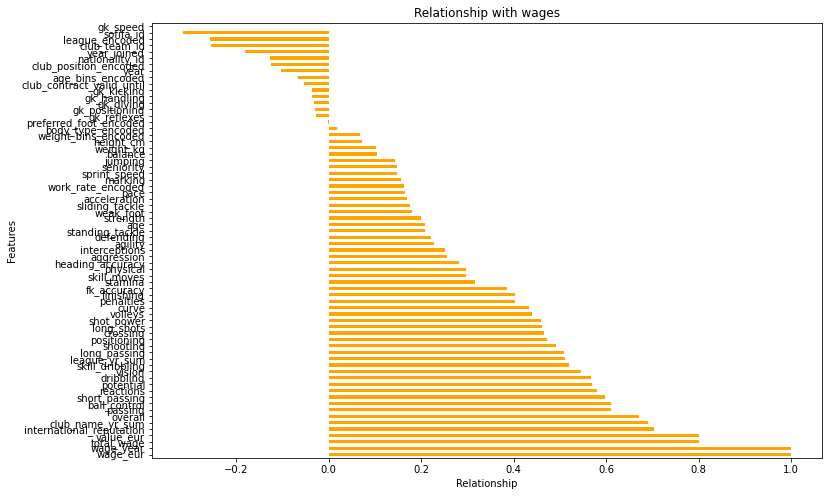

In [9]:
plt.figure(figsize = (12,8))
train.corr()['wage_eur'].sort_values(ascending=False).plot(kind='barh', color='orange')
plt.title('Relationship with wages')
plt.xlabel('Relationship')
plt.ylabel('Features')
plt.show()

In [10]:
features_cor =  train.corr()['wage_eur'].sort_values(ascending=False)
features_cor = pd.DataFrame(features_cor)
features_cor.head(15)

                          wage_eur
wage_eur                  1.000000
wage_year                 1.000000
total_wage                0.801682
value_eur                 0.799817
international_reputation  0.703696
club_name_yr_sum          0.690211
overall                   0.669972
passing                   0.611213
ball_control              0.610198
short_passing             0.597582
reactions                 0.579683
potential                 0.569505
dribbling                 0.566178
vision                    0.545699
skill_dribbling           0.520693

`Takeaways:` 
For this Exploration section I wil be focusing on the skills that are under or equal to 70 percent of correlation and greater then 48 percent. 
The list below will be the skills and stats that I will be focusing on.

- international_reputation
- overall
- passing
- ball_control


<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# MVP for Midfielders

In [11]:
# identifying mvp columns
mvp = ['international_reputation','overall','passing']
X_train = train[mvp]
y_train = train[['wage_eur']]

X_validate = validate[mvp]
y_validate = validate[['wage_eur']]

X_test = test[mvp]
y_test = test[['wage_eur']]

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Modeling for Midfielders
***
<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Baseline to beat = 14060.50
# RMSE

In [12]:
modeling.create_baseline(y_train, y_validate,' wage_eur')

RMSE using Mean
Train/In-Sample:  24203.75 
Validate/Out-of-Sample:  20560.17
RMSE using Median
Train/In-Sample:  26092.17 
Validate/Out-of-Sample:  20954.88


***
# Lasso + Lars

In [13]:
model = LinearRegression().fit(X_train, y_train.wage_eur)
predictions = model.predict(X_train)

In [14]:
modeling.lassolars_model(y_train,y_validate,X_train,X_validate)

RMSE for Lasso + Lars
Training/In-Sample:  14948.955407541534 
Validation/Out-of-Sample:  14189.464814961639


***
# TweedieRegressor

In [15]:
modeling.tweedie_model(y_train,y_validate,X_train,X_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  12142.637685135176 
Validation/Out-of-Sample:  11662.194075763458


<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>


# Evaluating Models

In [18]:
from sklearn.linear_model import LinearRegression
    #residuals
    y_train['lm_residuals'] = y_train.wage_eur_pred_lm - y_train['wage_eur']
    y_validate['lm_residuals'] = y_validate.wage_eur_pred_lm - y_validate['wage_eur']
    #residuals
    y_train['lars_residuals'] = y_train['wage_eur_pred_lars'] - y_train['wage_eur']
    y_validate['lars_residuals'] = y_validate['wage_eur_pred_lars'] - y_validate['wage_eur']
    #residuals
    y_train['glm_residuals'] = y_train['wage_eur_pred_glm'] - y_train['wage_eur']
    y_validate['glm_residuals'] = y_validate['wage_eur_pred_glm'] - y_validate['wage_eur']
    y_test = pd.DataFrame(y_test)
    y = pd.DataFrame(y_train.wage_eur)
    X = pd.DataFrame(X_train)
    # assuming X and y are already defined
    m = LinearRegression().fit(X, y)
    train['yhat'] = m.predict(X)

IndentationError: unexpected indent (37146732.py, line 3)

In [16]:
modeling.actual_vs_predicted(train,y_train,y_validate,X_train,X_validate,y_test)

AttributeError: 'DataFrame' object has no attribute 'wage_eur_pred_lm'

In [17]:
modeling.metrics(df,y_train,y_validate,X_train,X_validate)

RMSE using Mean
Train/In-Sample:  24203.75 
Validate/Out-of-Sample:  20560.17


AttributeError: 'DataFrame' object has no attribute 'yhat'